In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
engine.execute('SELECT date FROM measurement LIMIT 10').fetchall()

[('2010-01-01',),
 ('2010-01-02',),
 ('2010-01-03',),
 ('2010-01-04',),
 ('2010-01-06',),
 ('2010-01-07',),
 ('2010-01-08',),
 ('2010-01-09',),
 ('2010-01-10',),
 ('2010-01-11',)]

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from today
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

('2017-08-23',)
2016-08-23


In [15]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.prcp, Measurement.date).\
            filter(func.strftime(Measurement.date >= last_year)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(results)
prcp_df.columns = ["prcp", "date"]
prcp_df.set_index('date', inplace=True)
prcp_df.dropna()
prcp_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [16]:
# Sort the dataframe by date
sort_prcp = prcp_df.sort_values('date')

Text(0.5,0,'Date')

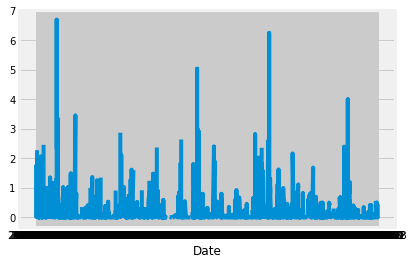

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(sort_prcp)
plt.xlabel("Date")

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# How many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [20]:
# What are the most active stations?
engine.execute('SELECT station, MAX(num_stations) FROM (SELECT station,COUNT(station) AS num_stations FROM Measurement GROUP BY station) AS count').fetchall()

[('USC00519281', 2772)]

In [21]:
# List the stations and the counts in descending order.
engine.execute('SELECT station,COUNT(station) AS num_stations FROM Measurement GROUP BY station ORDER BY 2 DESC').fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
engine.execute('SELECT s.station,MIN(tobs) AS min_temp,MAX(tobs) AS max_temp,AVG(tobs) AS average_temp FROM Measurement m, Station s WHERE s.station = m.station AND s.station = "USC00519281"').fetchall()


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
engine.execute('SELECT m.station,COUNT(m.station) FROM Measurement m GROUP BY m.station ORDER BY 2 DESC').fetchall()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
results2 = session.query(Measurement.tobs).\
            filter(func.strftime(Measurement.date >= last_year)).\
            filter((Measurement.station.like('USC00519281'))).all()
temp_df = pd.DataFrame(results2)
temp_df.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


Text(0.5,0,'Temperature')

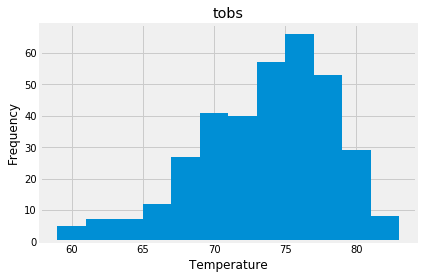

In [25]:
temp_df.hist(bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")

In [26]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
